<a href="https://colab.research.google.com/github/vkraus/bigdata_team7/blob/main/Team7_Block3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# installing jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#downloading .tgz installation file for Spache spark
!wget -q https://dlcdn.apache.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
# installing apache spark from downloaded file
!tar xf spark-3.5.4-bin-hadoop3.tgz
# installing findspark library
!pip install -q findspark

In [26]:
# importin necessary libraries fro this notebook
import os
import findspark
import numpy as np
import pandas as pd
from pyspark.sql.types import StringType # Import StringType from pyspark.sql.types
from pyspark.sql.window import Window # Import the Window class
from pyspark.sql.functions import when, first, col # Import necessary functions



In [27]:
#setting up paths for JDK and spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"
#initiating findspark
#findspark.init()
findspark.init()

In [28]:
from pyspark.sql import SparkSession
# Create a Spark session
spark = SparkSession.builder.appName("SparkDayOne").getOrCreate()

In [29]:
spark.getActiveSession

<bound method SparkSession.getActiveSession of <class 'pyspark.sql.session.SparkSession'>>

# Import train data

In [30]:
df_train = spark.read.csv("train.csv", header=True, inferSchema=True)
df_train.show()

+------+-----------+--------+---------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|           Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+---------------+----+-----------+

In [31]:
# Cleaning dle SSN

prepsat_ssn_value = "#F%$D@*&8"
colums_doplnit = ["Customer_ID", "Name", "Occupation", "SSN", "Age"]
window_part = Window.partitionBy("Customer_ID")

df_filled = df_train.withColumn(
    "Name", when(col("Name").isNull(), first("Name", True).over(window_part)).otherwise(col("Name"))
).withColumn(
    "Occupation", when(col("Occupation").isNull(), first("Occupation", True).over(window_part)).otherwise(col("Occupation"))
).withColumn(
    "SSN",
    when((col("SSN").isNull()) | (col("SSN") == prepsat_ssn_value), first(when(col("SSN") != prepsat_ssn_value, col("SSN")), True).over(window_part)).otherwise(col("SSN"))
).withColumn(
    "Age", when(col("Age").isNull(), first("Age", True).over(window_part)).otherwise(col("Age"))
)

df_filled.show()

+-------+-----------+--------+--------------+---+-----------+-------------+------------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|     ID|Customer_ID|   Month|          Name|Age|        SSN|   Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+-------+-----------+--------+--------------+---

In [32]:
# prompt: Show combinations of Customer_ID and SSN where single SSN is mapped to multiple different Customer_ID values

from pyspark.sql.functions import count

# Group by SSN and count the distinct Customer_IDs
ssn_counts = df_filled.groupBy("SSN").agg(count("Customer_ID").alias("customer_count"))

# Filter for SSNs with more than one distinct Customer_ID
multiple_customer_ids = ssn_counts.filter("customer_count > 1")

# Join with the original DataFrame to get the Customer_ID and SSN combinations
result_df = multiple_customer_ids.join(df_filled, "SSN", "inner").select("Customer_ID", "SSN")

# Show the results
result_df.show()

+-----------+-----------+
|Customer_ID|        SSN|
+-----------+-----------+
| CUS_0x1000|913-74-1218|
| CUS_0x1000|913-74-1218|
| CUS_0x1000|913-74-1218|
| CUS_0x1000|913-74-1218|
| CUS_0x1000|913-74-1218|
| CUS_0x1000|913-74-1218|
| CUS_0x1000|913-74-1218|
| CUS_0x1000|913-74-1218|
| CUS_0x1009|063-67-6938|
| CUS_0x1009|063-67-6938|
| CUS_0x1009|063-67-6938|
| CUS_0x1009|063-67-6938|
| CUS_0x1009|063-67-6938|
| CUS_0x1009|063-67-6938|
| CUS_0x1009|063-67-6938|
| CUS_0x1009|063-67-6938|
| CUS_0x100b|238-62-0395|
| CUS_0x100b|238-62-0395|
| CUS_0x100b|238-62-0395|
| CUS_0x100b|238-62-0395|
+-----------+-----------+
only showing top 20 rows



In [33]:
# prompt: Find unique combinations of Customer_ID and SSN where a single SSN is mapped to multiple Customer_ID values

from pyspark.sql.functions import count, col

# Group by SSN and count the number of unique Customer_IDs
ssn_counts = df_filled.groupBy("SSN").agg(count("Customer_ID").alias("customer_count"))

# Filter for SSNs with more than one Customer_ID
multiple_customer_ssns = ssn_counts.filter(col("customer_count") > 1)

# Join with the original DataFrame to get the Customer_IDs associated with these SSNs
result_df = multiple_customer_ssns.join(df_train, "SSN", "inner").select("Customer_ID", "SSN")

# Show the results
result_df.orderBy(col("SSN")).show()

+-----------+-----------+
|Customer_ID|        SSN|
+-----------+-----------+
| CUS_0x1e84|000-08-1349|
| CUS_0x1e84|000-08-1349|
| CUS_0x1e84|000-08-1349|
| CUS_0x1e84|000-08-1349|
| CUS_0x1e84|000-08-1349|
| CUS_0x1e84|000-08-1349|
| CUS_0x1e84|000-08-1349|
| CUS_0x1e84|000-08-1349|
| CUS_0x11a4|000-40-3312|
| CUS_0x11a4|000-40-3312|
| CUS_0x11a4|000-40-3312|
| CUS_0x11a4|000-40-3312|
| CUS_0x11a4|000-40-3312|
| CUS_0x11a4|000-40-3312|
| CUS_0x11a4|000-40-3312|
| CUS_0x11a4|000-40-3312|
| CUS_0x1383|000-58-0568|
| CUS_0x1383|000-58-0568|
| CUS_0x1383|000-58-0568|
| CUS_0x1383|000-58-0568|
+-----------+-----------+
only showing top 20 rows



# Clean up underscores

In [34]:
def find_underscore_columns(spark_df):

    underscore_columns = []
    for col in spark_df.columns:
        # Check if column is of string type
        if isinstance(spark_df.schema[col].dataType, (StringType)): # Use the imported StringType
          # Convert the column to pandas series to enable string functions
          pandas_series = spark_df.select(col).toPandas()[col]
          if any('_' in str(x) for x in pandas_series):
            underscore_columns.append(col)

    return underscore_columns

# Example usage (assuming df_train is your DataFrame)
underscore_cols = find_underscore_columns(df_filled)

# Remove 'Customer_ID' if present
if 'Customer_ID' in underscore_cols:
    underscore_cols.remove('Customer_ID')

underscore_cols

['Age',
 'Occupation',
 'Annual_Income',
 'Num_of_Loan',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Credit_Mix',
 'Outstanding_Debt',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [35]:
from pyspark.sql.functions import regexp_replace

def remove_underscores_from_columns(spark_df, cols_to_modify):
    new_df = spark_df
    for col in cols_to_modify:
        new_df = new_df.withColumn(col, regexp_replace(col, "_", ""))
    return new_df

new_df_train = remove_underscores_from_columns(df_filled, underscore_cols)
new_df_train.show()

+-------+-----------+--------+--------------+---+-----------+------------+------------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|     ID|Customer_ID|   Month|          Name|Age|        SSN|  Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+-------+-----------+--------+--------------+---+-

Clean from underscores

# Statistics for individual columns

In [36]:
# Identifikace numerických sloupců
numerical_cols = [field.name for field in new_df_train.schema.fields if "IntegerType" in str(field.dataType) or "DoubleType" in str(field.dataType)]

# Popis numerických sloupců
for col_name in numerical_cols:
    print(f"Statistiky pro sloupec: {col_name}")
    new_df_train.select(col_name).describe().show()

Statistiky pro sloupec: Monthly_Inhand_Salary
+-------+---------------------+
|summary|Monthly_Inhand_Salary|
+-------+---------------------+
|  count|                84998|
|   mean|    4194.170849600515|
| stddev|    3183.686166873265|
|    min|    303.6454166666666|
|    max|   15204.633333333333|
+-------+---------------------+

Statistiky pro sloupec: Num_Bank_Accounts
+-------+-----------------+
|summary|Num_Bank_Accounts|
+-------+-----------------+
|  count|           100000|
|   mean|         17.09128|
| stddev|117.4048344273482|
|    min|               -1|
|    max|             1798|
+-------+-----------------+

Statistiky pro sloupec: Num_Credit_Card
+-------+------------------+
|summary|   Num_Credit_Card|
+-------+------------------+
|  count|            100000|
|   mean|          22.47443|
| stddev|129.05741011009866|
|    min|                 0|
|    max|              1499|
+-------+------------------+

Statistiky pro sloupec: Interest_Rate
+-------+------------------+
|

# Identify data types

In [37]:
print("Data Types:")
new_df_train.printSchema()

Data Types:
root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nul

# Basic statistics for numerical columns

In [38]:
new_df_train.describe().show()

+-------+-------+-----------+------+------+-----------------+-----------+----------+------------------+---------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+-----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+--------------------+------------+
|summary|     ID|Customer_ID| Month|  Name|              Age|        SSN|Occupation|     Annual_Income|Monthly_Inhand_Salary| Num_Bank_Accounts|   Num_Credit_Card|     Interest_Rate|      Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix| Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|     Monthly_Balance|Credit_S

# Find duplicates

In [39]:
df_duplicates = new_df_train.groupBy(df_train.columns).count().filter("count > 1")
df_duplicates.show()

+---+-----------+-----+----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------------+-----+
| ID|Customer_ID|Month|Name|Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Credit_Score|count|
+---+-----------+-----+----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+---

# Find missing values

In [40]:
from pyspark.sql.functions import col, sum

missing_values = new_df_train.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_train.columns])
missing_values.show()

+---+-----------+-----+----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------------+
| ID|Customer_ID|Month|Name|Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Credit_Score|
+---+-----------+-----+----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+---

In [41]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# Seznam sloupců, které chceme převést na číselné hodnoty
numeric_columns = ["Age", "Annual_Income", "Monthly_Inhand_Salary",
                   "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate",
                   "Num_of_Loan", "Num_of_Delayed_Payment",
                   "Changed_Credit_Limit", "Num_Credit_Inquiries",
                   "Outstanding_Debt", "Credit_Utilization_Ratio",
                   "Credit_History_Age", "Total_EMI_per_month",
                   "Amount_invested_monthly", "Monthly_Balance"]

# Převod každého sloupce na číselný typ s ošetřením chybějících nebo neplatných hodnot
for column in numeric_columns:
    data = new_df_train.withColumn(column, col(column).cast("double"))

data.show()

+-------+-----------+--------+--------------+---+-----------+------------+------------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|     ID|Customer_ID|   Month|          Name|Age|        SSN|  Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+-------+-----------+--------+--------------+---+-

# Data types after type casting

In [42]:
data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable = true

In [43]:
# prompt: Suggest 10 new features and add them to the "data" dataframe

from pyspark.sql.functions import rand, when, lit

# Assuming 'data' is your DataFrame (replace with the actual name if different)
# and it's already defined in your existing code.
# Example: data = new_df_train

# 1. Debt to Income Ratio
data = data.withColumn("Debt_to_Income_Ratio", col("Outstanding_Debt") / col("Annual_Income"))

# 2. Savings_Rate: Podíl mìsíèního zùstatku k mìsíènímu pøíjmu v procentech.
# Ukazuje, jak efektivnì zákazník šetøí peníze z mìsíèního pøíjmu.
data = data.withColumn(
    "Savings_Rate",
    when(col("Monthly_Inhand_Salary") > 0, (col("Monthly_Balance") / col("Monthly_Inhand_Salary")))
     .otherwise(None)
)

# 3. Total Delayed Days
data = data.withColumn(
    "Total_Delayed_Days",
    (col("Num_of_Delayed_Payment") * col("Delay_from_due_date")).cast("float")
)

# 4. EMI to Income Ratio
data = data.withColumn(
    "EMI_to_Income_Ratio",
    (col("Total_EMI_per_month") / col("Monthly_Inhand_Salary")).cast("float")
)

# 5. Loan Type Factor
data = data.withColumn(
    "Loan_Type_Factor",
    when(col("Type_of_Loan").like("%Home%"), col("Num_of_Loan") * 1.5)
    .when(col("Type_of_Loan").like("%Car%"), col("Num_of_Loan") * 1.2)
    .otherwise(col("Num_of_Loan"))
)

# 6. Financial Health Score
data = data.withColumn(
    "Financial_Health_Score",
    (col("Annual_Income") - col("Outstanding_Debt") - (col("Total_EMI_per_month") * 12)).cast("float")
)

# 7. Income to Credit Card
data = data.withColumn(
    "Income_Per_Credit_Card",
    (col("Annual_Income") / col("Num_Credit_Card")).cast("float")
)

# 8. Delays Per Loan
new_data = data.withColumn(
    "Delays_Per_Loan",
    (col("Num_of_Delayed_Payment") / col("Num_of_Loan")).cast("float")
)

new_data.show()

+-------+-----------+--------+--------------+---+-----------+------------+------------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+--------------------+-------------------+------------------+-------------------+----------------+----------------------+----------------------+---------------+
|     ID|Customer_ID|   Month|          Name|Age|        SSN|  Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_

In [44]:
new_features = [
    "Debt_to_Income_Ratio",
    "Savings_Rate",
    "Total_Delayed_Days",
    "EMI_to_Income_Ratio",
    "Loan_Type_Factor",
    "Financial_Health_Score",
    "Income_Per_Credit_Card",
    "Delays_Per_Loan"
]

# Statistical analysis of new features

In [45]:
for col_name in new_features:
    print(f"Description for column: {col_name}")
    new_data.select(col_name).describe().show()
    print("-" * 40)

Description for column: Debt_to_Income_Ratio
+-------+--------------------+
|summary|Debt_to_Income_Ratio|
+-------+--------------------+
|  count|              100000|
|   mean| 0.06001770569639998|
| stddev| 0.08713630359240221|
|    min|4.086799670023885E-7|
|    max|  0.6832515548332656|
+-------+--------------------+

----------------------------------------
Description for column: Savings_Rate
+-------+--------------------+
|summary|        Savings_Rate|
+-------+--------------------+
|  count|               83969|
|   mean|-1.09013204341347...|
| stddev|1.287145481078284...|
|    min|-2.26454146998180...|
|    max|   0.876486881388083|
+-------+--------------------+

----------------------------------------
Description for column: Total_Delayed_Days
+-------+------------------+
|summary|Total_Delayed_Days|
+-------+------------------+
|  count|             92998|
|   mean| 693.8928579109228|
| stddev| 5768.251801856735|
|    min|          -16645.0|
|    max|          263438.0|
+

# Data types of new features

In [46]:
for col_name in new_features:
    print(f"Data type of column '{col_name}': {new_data.schema[col_name].dataType}")

Data type of column 'Debt_to_Income_Ratio': DoubleType()
Data type of column 'Savings_Rate': DoubleType()
Data type of column 'Total_Delayed_Days': FloatType()
Data type of column 'EMI_to_Income_Ratio': FloatType()
Data type of column 'Loan_Type_Factor': StringType()
Data type of column 'Financial_Health_Score': FloatType()
Data type of column 'Income_Per_Credit_Card': FloatType()
Data type of column 'Delays_Per_Loan': FloatType()


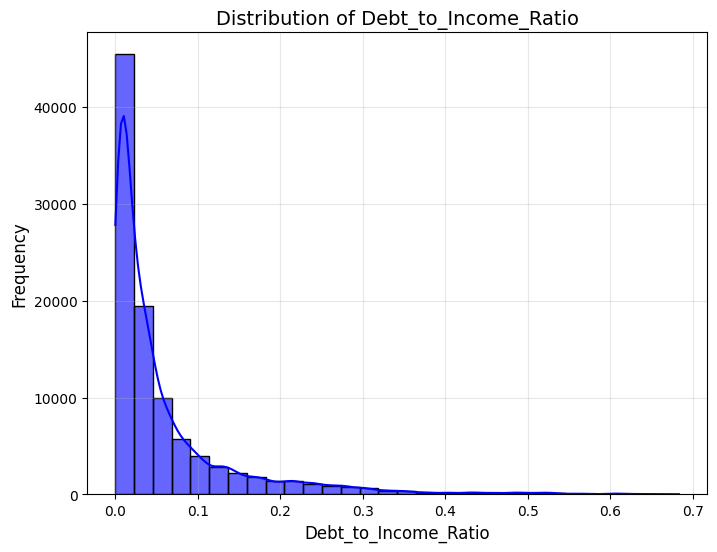

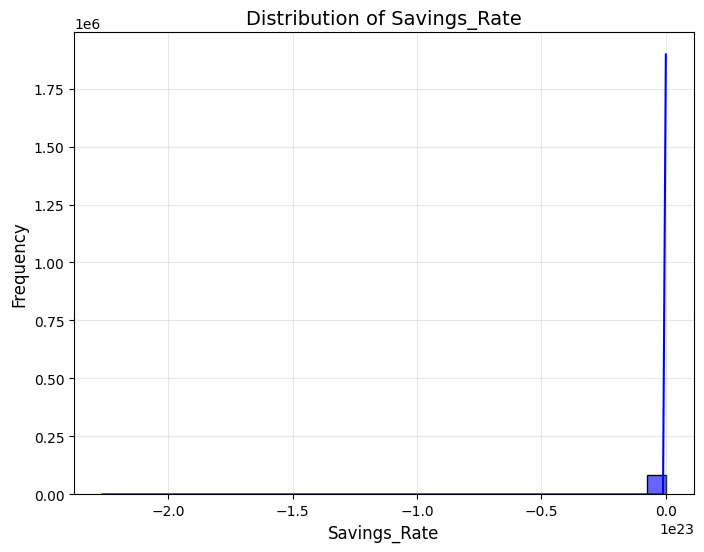

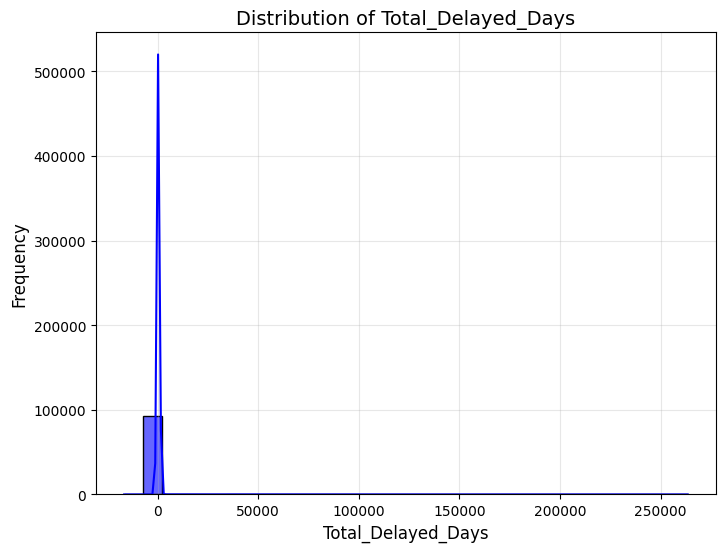

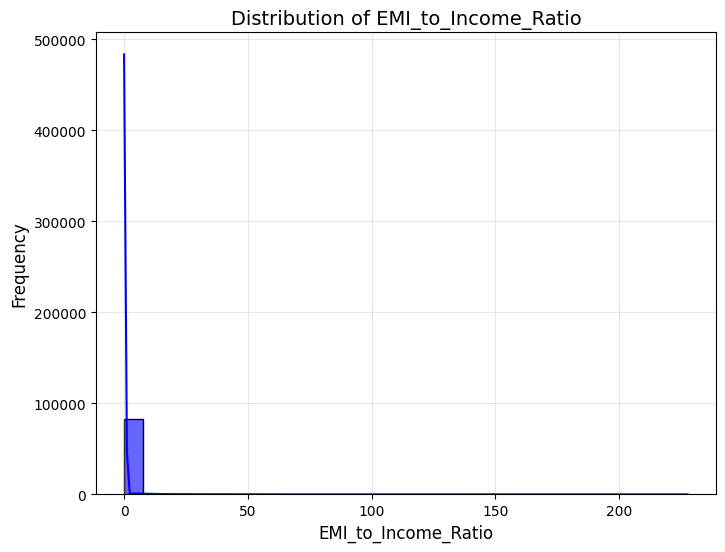

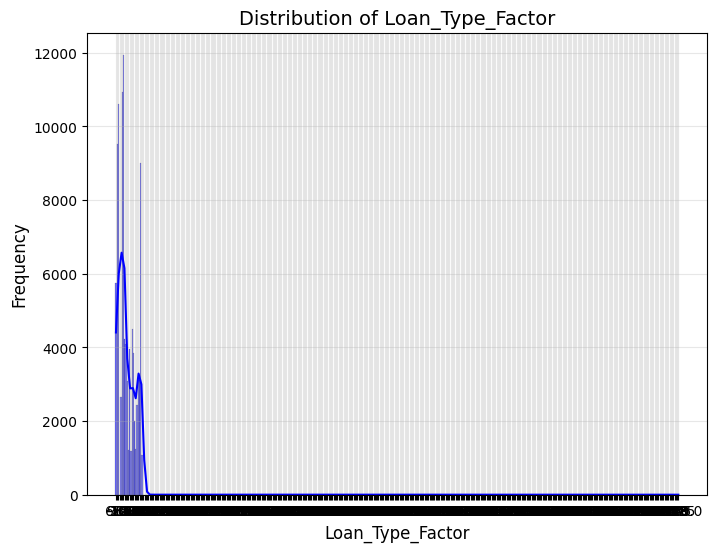

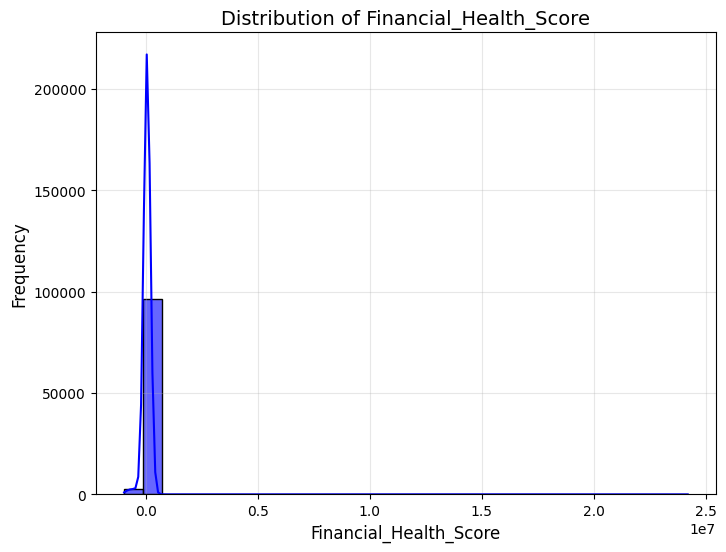

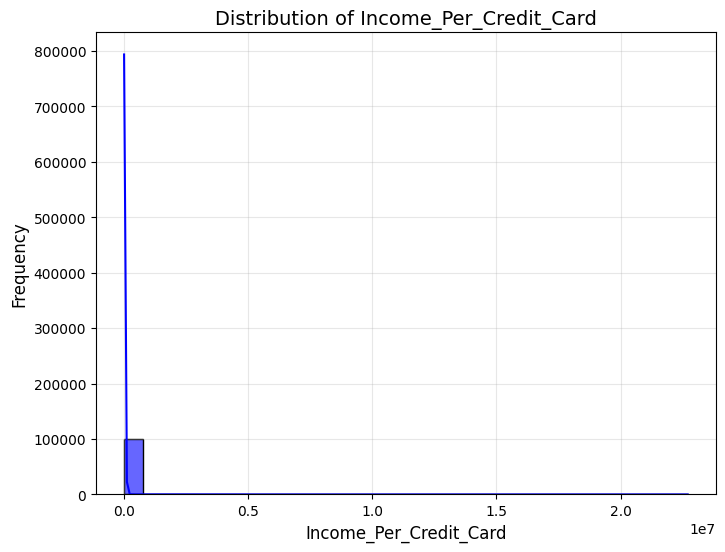

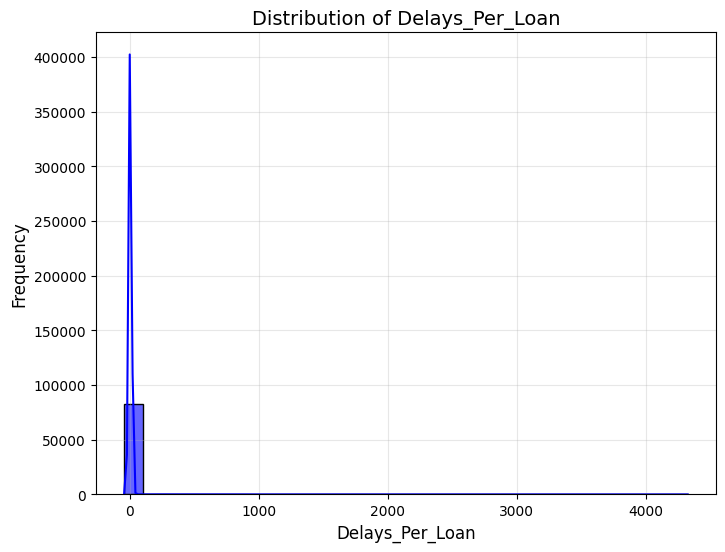

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distributions
def plot_feature_distributions(data, new_features, bins=30):
    # Convert the PySpark DataFrame to Pandas before plotting
    pandas_df = data.select(new_features).toPandas()
    for feature in new_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(pandas_df[feature], kde=True, bins=bins, color='blue', alpha=0.6)
        plt.title(f'Distribution of {feature}', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

# Call the function
plot_feature_distributions(new_data, new_features)

# Target leakage

Correlation matrix:
                         Debt_to_Income_Ratio  Savings_Rate  \
Debt_to_Income_Ratio                1.000000      0.002352   
Savings_Rate                        0.002352      1.000000   
Total_Delayed_Days                  0.038586      0.000926   
EMI_to_Income_Ratio                 0.074483     -0.001919   
Loan_Type_Factor                    0.018637      0.000010   
Financial_Health_Score             -0.073507      0.000949   
Income_Per_Credit_Card             -0.067221      0.000746   
Delays_Per_Loan                    -0.022042      0.000717   
Credit_Score                       -0.169432      0.002284   

                        Total_Delayed_Days  EMI_to_Income_Ratio  \
Debt_to_Income_Ratio              0.038586             0.074483   
Savings_Rate                      0.000926            -0.001919   
Total_Delayed_Days                1.000000             0.007536   
EMI_to_Income_Ratio               0.007536             1.000000   
Loan_Type_Factor       

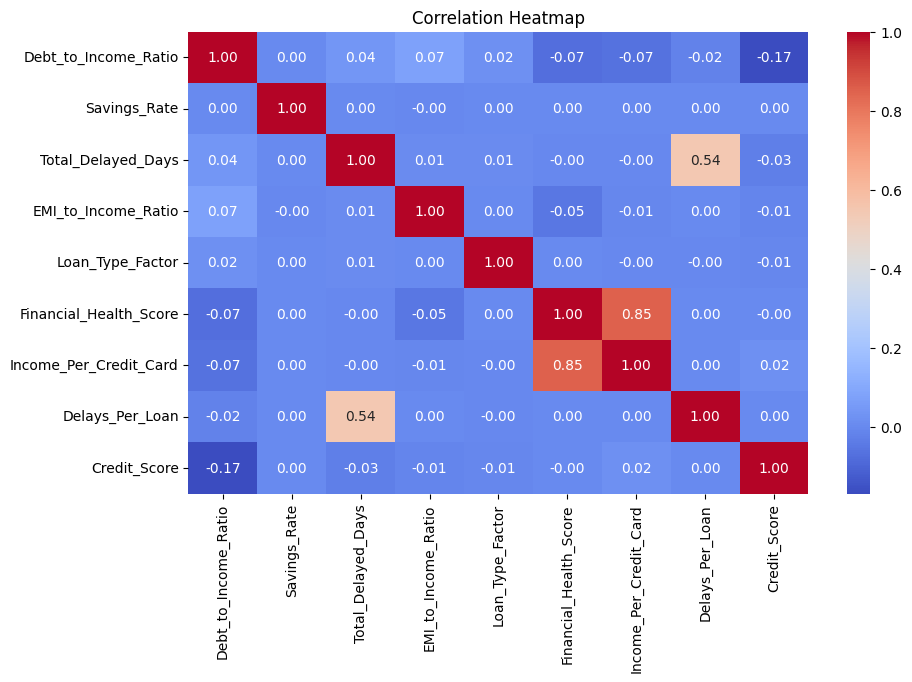

In [48]:
target_column = "Credit_Score"  # Replace with your target variable

# 1. Correlation analysis (for numeric target)
# Convert the column to a Pandas Series for type checking
target_column_type = new_data.select(target_column).toPandas()[target_column].dtype

# Check if the target column is numeric or object (string)
if pd.api.types.is_numeric_dtype(target_column_type):
    # Convert to Pandas DataFrame for correlation calculation
    pandas_df = new_data[new_features + [target_column]].toPandas()
    correlation_matrix = pandas_df.corr()
    print("Correlation matrix:\n", correlation_matrix)

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
else:  # Handle categorical target variable
    # Convert 'Credit_Score' to numerical representation
    from pyspark.sql.functions import when

    new_data = new_data.withColumn(
        target_column,
        when(col(target_column) == "Good", 1)
        .when(col(target_column) == "Standard", 0)
        .otherwise(None)  # Handle other categories if needed
    )
    # Now you can proceed with the correlation analysis using the updated 'new_data'
    pandas_df = new_data[new_features + [target_column]].toPandas()
    correlation_matrix = pandas_df.corr()
    print("Correlation matrix:\n", correlation_matrix)

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


# 2. Distribution across target categories (for categorical target)
# ... (rest of your code remains the same)

In [57]:
all_features = [
    "Age",
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Num_of_Delayed_Payment",
    "Changed_Credit_Limit",
    "Num_Credit_Inquiries",
    "Outstanding_Debt",
    "Credit_Utilization_Ratio",
    # "Credit_History_Age",
    "Total_EMI_per_month",
     "Amount_invested_monthly",
    "Monthly_Balance",
    "Debt_to_Income_Ratio",
    "Savings_Rate",
    "Total_Delayed_Days",
    "EMI_to_Income_Ratio",
    "Loan_Type_Factor",
    "Financial_Health_Score",
    "Income_Per_Credit_Card",
    "Delays_Per_Loan"
]

# Převod každého sloupce na číselný typ s ošetřením chybějících nebo neplatných hodnot
for column in all_features:
    new_data = new_data.withColumn(column, col(column).cast("double"))

new_data.printSchema()


root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: double (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: double (nullable = true)
 

Correlation matrix:
                                Age  Annual_Income  Monthly_Inhand_Salary  \
Age                       1.000000      -0.000533               0.003029   
Annual_Income            -0.000533       1.000000               0.030519   
Monthly_Inhand_Salary     0.003029       0.030519               1.000000   
Num_Bank_Accounts         0.002466      -0.004627              -0.010819   
Num_Credit_Card          -0.001791       0.001250              -0.005049   
Interest_Rate            -0.005667      -0.002908              -0.006422   
Num_of_Loan              -0.001273       0.001464              -0.010398   
Num_of_Delayed_Payment   -0.002545       0.001180               0.000917   
Changed_Credit_Limit     -0.003048       0.000615              -0.174933   
Num_Credit_Inquiries     -0.002022       0.003153              -0.008867   
Outstanding_Debt         -0.001995      -0.003706              -0.269727   
Credit_Utilization_Ratio  0.002774       0.010316               0.1

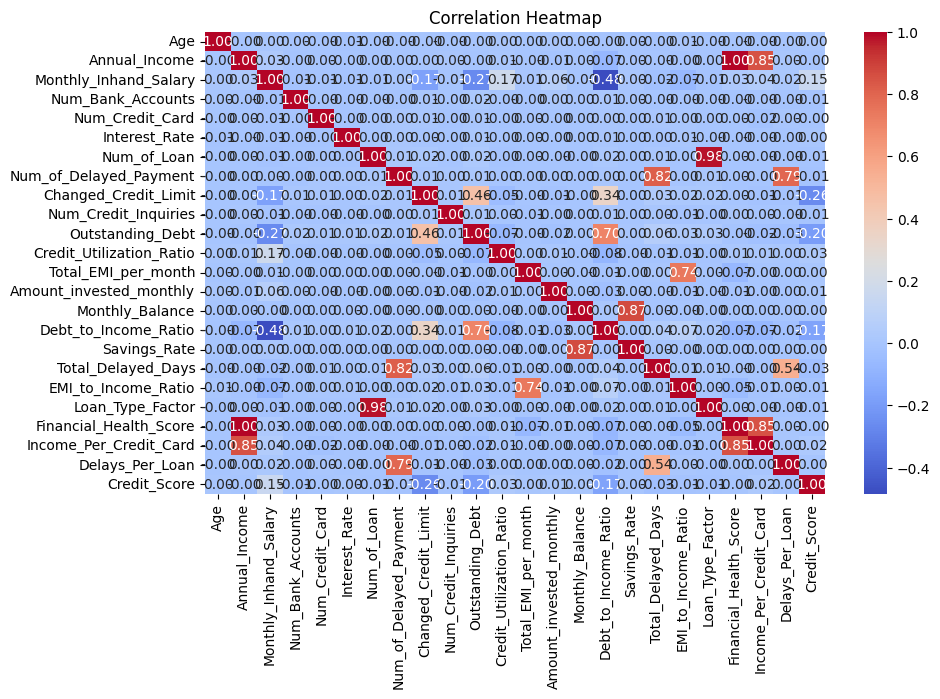

In [58]:
target_column = "Credit_Score"  # Replace with your target variable

# 1. Correlation analysis (for numeric target)
# Convert the column to a Pandas Series for type checking
target_column_type = new_data.select(target_column).toPandas()[target_column].dtype

# Check if the target column is numeric or object (string)
if pd.api.types.is_numeric_dtype(target_column_type):
    # Convert to Pandas DataFrame for correlation calculation
    pandas_df = new_data[all_features + [target_column]].toPandas()
    correlation_matrix = pandas_df.corr()
    print("Correlation matrix:\n", correlation_matrix)

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
else:  # Handle categorical target variable
    # Convert 'Credit_Score' to numerical representation
    from pyspark.sql.functions import when

    new_data = new_data.withColumn(
        target_column,
        when(col(target_column) == "Good", 1)
        .when(col(target_column) == "Standard", 0)
        .otherwise(None)  # Handle other categories if needed
    )
    # Now you can proceed with the correlation analysis using the updated 'new_data'
    pandas_df = new_data[all_features + [target_column]].toPandas()
    correlation_matrix = pandas_df.corr()
    print("Correlation matrix:\n", correlation_matrix)

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


# 2. Distribution across target categories (for categorical target)
# ... (rest of your code remains the same)

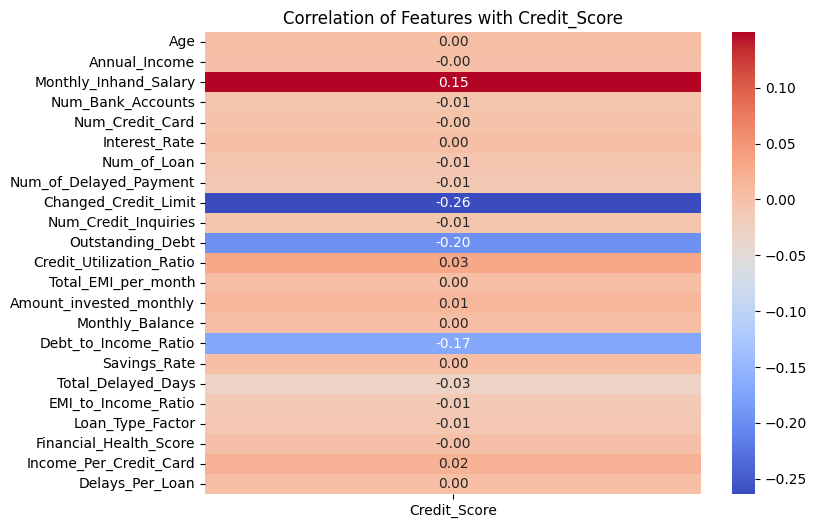

In [59]:
target_column = "Credit_Score"  # Replace with your target variable

# 1. Correlation analysis (for numeric target)
# Convert the column to a Pandas Series for type checking
target_column_type = new_data.select(target_column).toPandas()[target_column].dtype

# Check if the target column is numeric or object (string)
if pd.api.types.is_numeric_dtype(target_column_type):
    # Convert to Pandas DataFrame for correlation calculation
    pandas_df = new_data[all_features + [target_column]].toPandas()
    correlation_matrix = pandas_df.corr()

    # Extract correlations with the target column
    target_correlations = correlation_matrix[[target_column]].drop(index=target_column)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        target_correlations,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        cbar=True,
        yticklabels=target_correlations.index
    )
    plt.title(f"Correlation of Features with {target_column}")
    plt.show()

else:  # Handle categorical target variable
    # Convert 'Credit_Score' to numerical representation
    from pyspark.sql.functions import when

    new_data = new_data.withColumn(
        target_column,
        when(col(target_column) == "Good", 1)
        .when(col(target_column) == "Standard", 0)
        .otherwise(None)  # Handle other categories if needed
    )
    # Now you can proceed with the correlation analysis using the updated 'new_data'
    pandas_df = new_data[all_features + [target_column]].toPandas()
    correlation_matrix = pandas_df.corr()

    # Extract correlations with the target column
    target_correlations = correlation_matrix[[target_column]].drop(index=target_column)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        target_correlations,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        cbar=True,
        yticklabels=target_correlations.index
    )
    plt.title(f"Correlation of Features with {target_column}")
    plt.show()


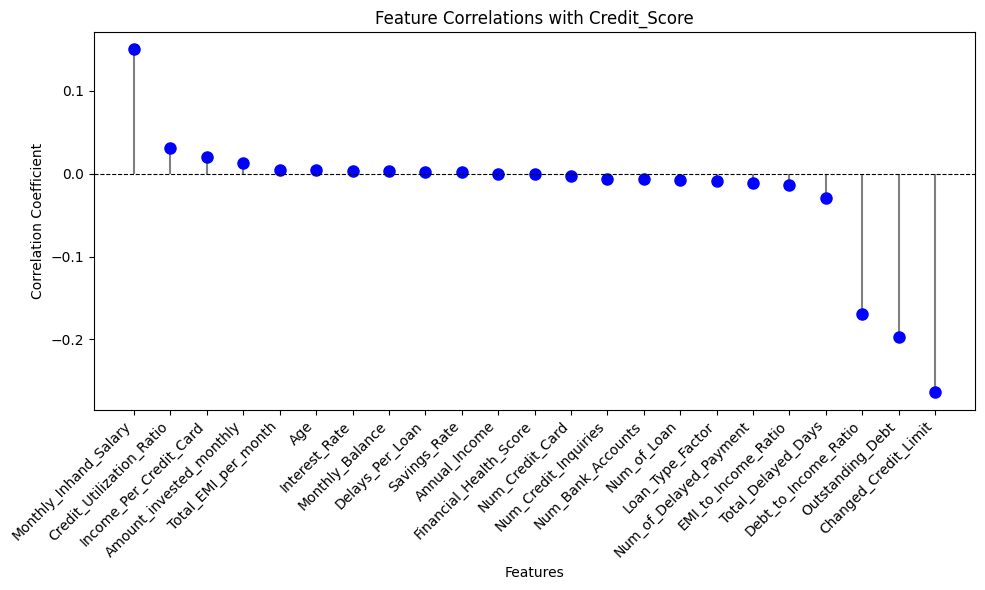

In [60]:
# Extract correlations with the target variable
target_correlations = correlation_matrix[target_column].drop(target_column)

# Sort correlations
target_correlations = target_correlations.sort_values(ascending=False)

# Plot as a lollipop chart
plt.figure(figsize=(10, 6))
markerline, stemlines, baseline = plt.stem(target_correlations, basefmt=" ", linefmt="gray", markerfmt="o")
plt.setp(markerline, color="blue", markersize=8)  # Adjust marker style
plt.setp(stemlines, color="gray")  # Adjust stem line style
plt.title(f"Feature Correlations with {target_column}")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.xticks(range(len(target_correlations)), target_correlations.index, rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()
